In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import random
from grid import *
from wfc import *
from utils import *
from floor import *
import cv2 as cv
import os

file calledfloor_10_small.png
file calledfloor_11_small.png
file calledfloor_1_small.png
file calledfloor_2_small.png
file calledfloor_3_small.png
file calledfloor_4_small.png
file calledfloor_5_small.png
file calledfloor_6_small.png
file calledfloor_7_small.png
file calledfloor_8_small.png
file calledfloor_9_small.png


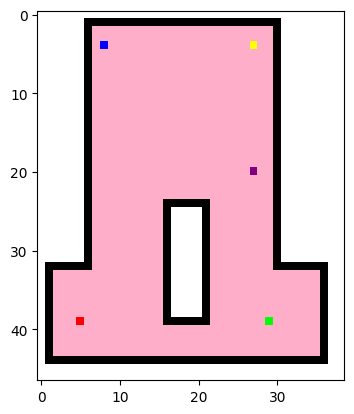

In [2]:
floorplans = []
data_dir = "data/pre_defined/small/"
for filename in os.listdir(data_dir):
    if filename.lower().endswith(('.png', 'jpeg')):
        print(f"file called{filename}")
        filepath = os.path.join(data_dir, filename)
        floorplan = cv.imread(filepath)
        floorplan = cv.cvtColor(floorplan, cv.COLOR_BGR2RGB)
        plt.imshow(floorplan)
        floorplans.append(floorplan)

In [3]:
def plot_rect(size, rect):
    fig, axes = plt.subplots(size[1], size[0], figsize=size, gridspec_kw={'wspace': 0, 'hspace': 0})
    show = True
    for ax, row in zip(axes.flatten(), rect.flatten()):
        image_data = np.array(row.ins, dtype=float)
        ax.imshow(image_data, cmap='gray', aspect='auto')
        ax.axis('off')


    plt.tight_layout()
    plt.show()

def int_to_wall(rect, Wall=Wall):
    """
    Converts a numpy array of integers to an array of Wall objects.
    Each integer is transformed to Wall(n) where n is the integer value.
    """
    return np.vectorize(lambda x: Wall(17) if (((128 <= x) and (144 >= x)) or ((x >18) and (x<=21))) else Wall(x))(rect)

In [4]:
def extract_wall_segments(grid, pixel_size=1, min_run: int = 2):
    """
    Extract horizontal (top edges) and vertical (right edges) wall segments.
    """
    segments = []
    h, w = grid.shape

    # Horizontal runs (top edges)
    for y in range(h):
        run_start = None
        length = 0
        for x in range(w + 1):
            is_wall = x < w and grid[y, x] == 1
            if is_wall:
                if run_start is None:
                    run_start = x
                length += 1
            else:
                if run_start is not None and length >= min_run:
                    x0 = run_start * pixel_size
                    x1 = (run_start + length) * pixel_size
                    y_top = (y+0.5) * pixel_size  # Top edge of the row
                    segments.append(((x0, y_top), (x1, y_top)))
                run_start = None
                length = 0

    # Vertical runs (right edges)
    for x in range(w):
        run_start = None
        length = 0
        for y in range(h + 1):
            is_wall = y < h and grid[y, x] == 1
            if is_wall:
                if run_start is None:
                    run_start = y
                length += 1
            else:
                if run_start is not None and length >= min_run:
                    y0 = run_start * pixel_size
                    y1 = (run_start + length) * pixel_size
                    x_right = (x+0.5) * pixel_size  # Right edge of the column
                    segments.append(((x_right, y0), (x_right, y1)))
                run_start = None
                length = 0

    return segments

def extract_rooms(grid: np.ndarray):
    """
    Extract room cell coordinates for grid values not 0, 1, 2, 3, or 4.
    """
    rooms = []
    # Create a mask for cells not in {0,1,2,3,4}
    mask = ~np.isin(grid, [0, 1, 2, 3, 4])
    ys, xs = np.where(mask)
    for y, x in zip(ys, xs):
        rooms.append((x, y))  # Store cell indices (like interiors)
    return rooms


def extract_door_points(grid: np.ndarray) -> list[tuple[int, int]]:
    """
    Extract door cell centers for grid values >=2.
    """
    doors = []
    ys, xs = np.where((grid == 2) | (grid == 3))
    for y, x in zip(ys, xs):
        doors.append((x + 0.5, y + 0.5))
    return doors


def parse_grid_to_blueprint(grid, pixel_size = 1,min_wall_run: int = 2):
    """
    High-level parsing function.

    Returns a dictionary with:
      - 'wall_segments': list of ((x0,y0),(x1,y1))
      - 'door_centers': list of (x,y)
      - 'interior_cells': list of (x,y)
    """
    walls = extract_wall_segments(grid, pixel_size, min_wall_run)
    doors = extract_door_points(grid)
    interiors = []
    ys, xs = np.where(grid == 4)
    for y, x in zip(ys, xs):
        #interiors.append((x + 0.5, y + 0.5))
        interiors.append((x, y))

    rooms = extract_rooms(grid)  # Extract room cells
    return {
        'wall_segments': walls,
        'door_centers': doors,
        'interior_cells': interiors,
        'room_cells': rooms  # Include room cells in the output
    }

def visualize_blueprint(parsed, 
                        figsize=(8,8), 
                        wall_linewidth=4, 
                        door_size=0.3, 
                        interior_fc='#f5f5a5', 
                        room_fc='#a5d8f5',  # New parameter for room color
                        show_interior=True,
                        show_rooms=True):    # New parameter to toggle rooms):
    """
    Visualize wall segments, door points, and (optionally) interior cells
    as a clean blueprint.

    Args:
        parsed         : dict from parse_grid_to_blueprint, with keys
                         'wall_segments', 'door_centers', 'interior_cells'
        figsize        : figure size tuple
        wall_linewidth : thickness of wall lines
        door_size      : marker size for doors
        interior_fc    : fill color for interior cell patches
        show_interior  : whether to draw interior cell highlights
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_facecolor('white')

    # Walls
    walls = parsed['wall_segments']
    if walls:
        # Corrected: removed subtraction of 1 from coordinates
        segs = walls  # Directly use the wall segments as generated
        lc = LineCollection(segs, linewidths=wall_linewidth, colors='black')
        ax.add_collection(lc)

    # Doors (unchanged)
    doors = parsed['door_centers']
    if doors:
        xs, ys = zip(*doors)
        ax.scatter(xs, ys, s=door_size*100, marker='_', color='red', linewidths=2, zorder=3)

    # Interior cells (optional)
    if show_rooms:
        from matplotlib.patches import Rectangle
        for (ix, iy) in parsed['room_cells']:
            rect = Rectangle((ix - 0.5, iy - 0.5), 1, 1,
                             facecolor=room_fc, edgecolor='none', zorder=0)
            ax.add_patch(rect)

    # Flip Y so that origin is bottom-left like CAD
    ax.invert_yaxis()

    # autoscale to contents
    ax.autoscale()
    plt.tight_layout()
    return fig, ax

[(1, 1), (1, 37), (9, 10), (9, 14), (11, 10), (11, 14), (19, 22), (19, 37), (28, 1), (28, 22)]
(35, 3, 144)
(3, 4, 128)
(34, 17, 132)
(3, 26, 129)
(20, 26, 130)


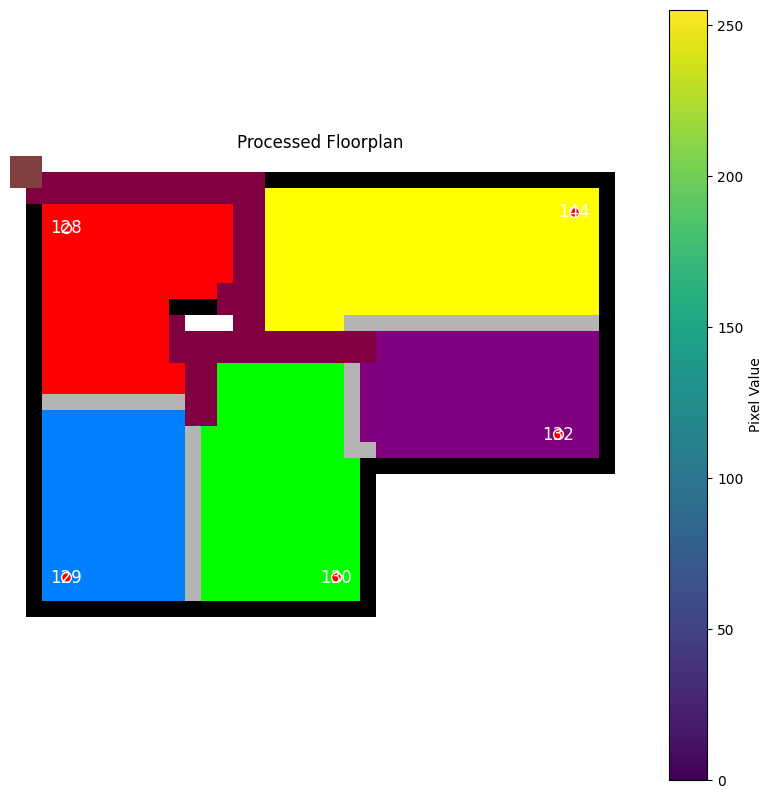

(35, 3, 144)
(3, 4, 128)
(34, 17, 132)
(3, 26, 129)
(20, 26, 130)


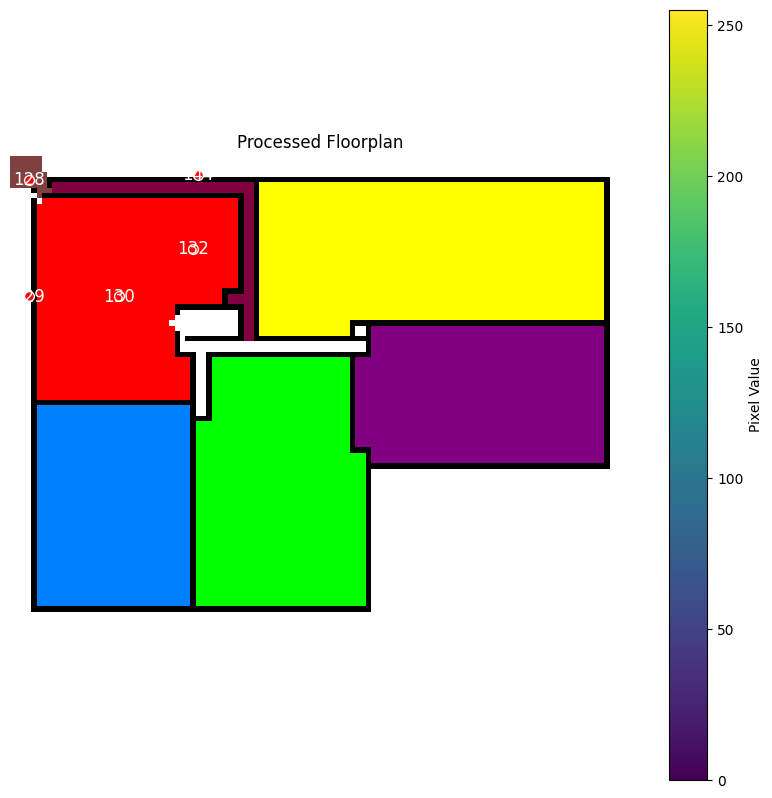

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (8, 19), (8, 29), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (21, 19), (21, 29), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (26, 1), (26, 2), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (26, 8), (26, 9), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (26, 16), (26, 17), (26, 18), (26, 19)]
(14, 2, 132)
(2, 4, 130)
(27, 15, 129)
(3, 24, 128)
(15, 24, 144)


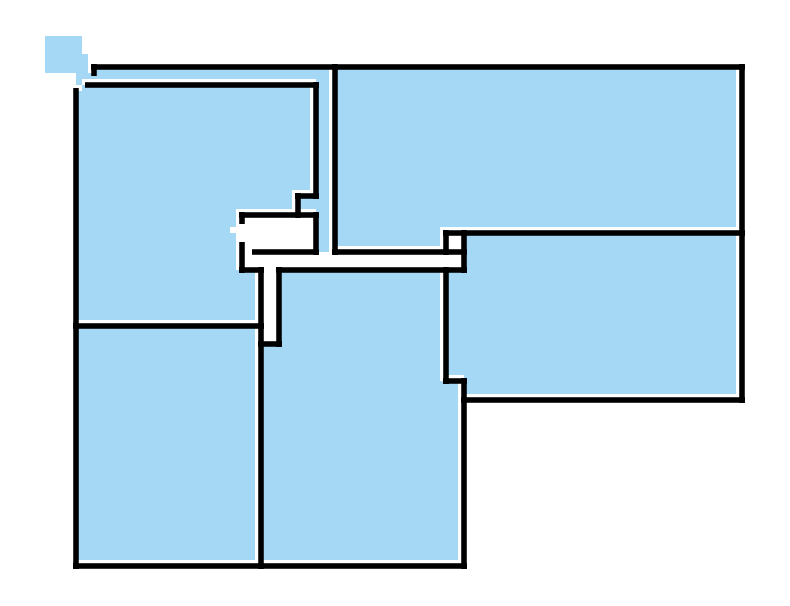

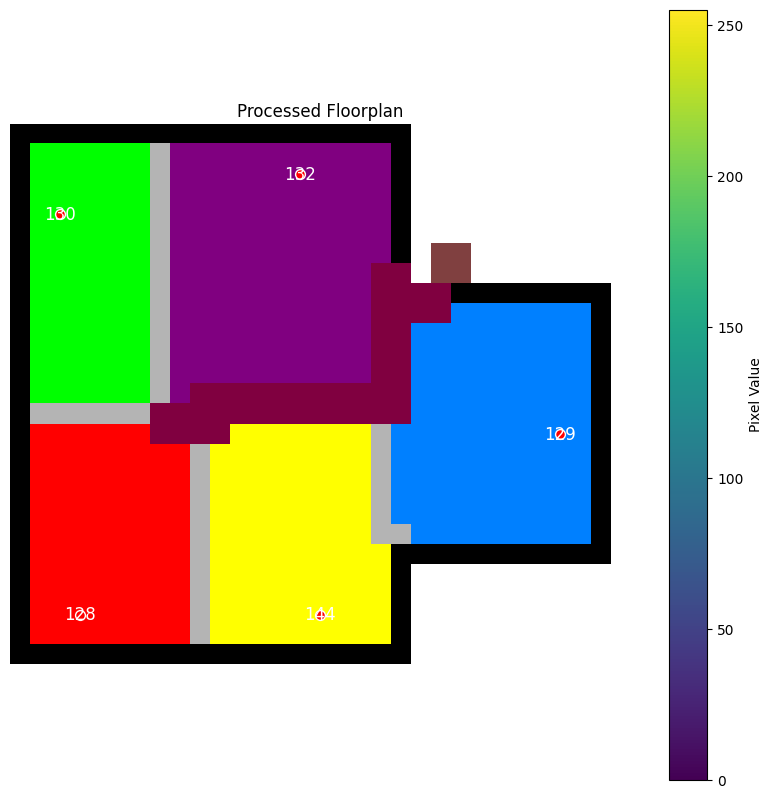

(14, 2, 132)
(2, 4, 130)
(27, 15, 129)
(3, 24, 128)
(15, 24, 144)


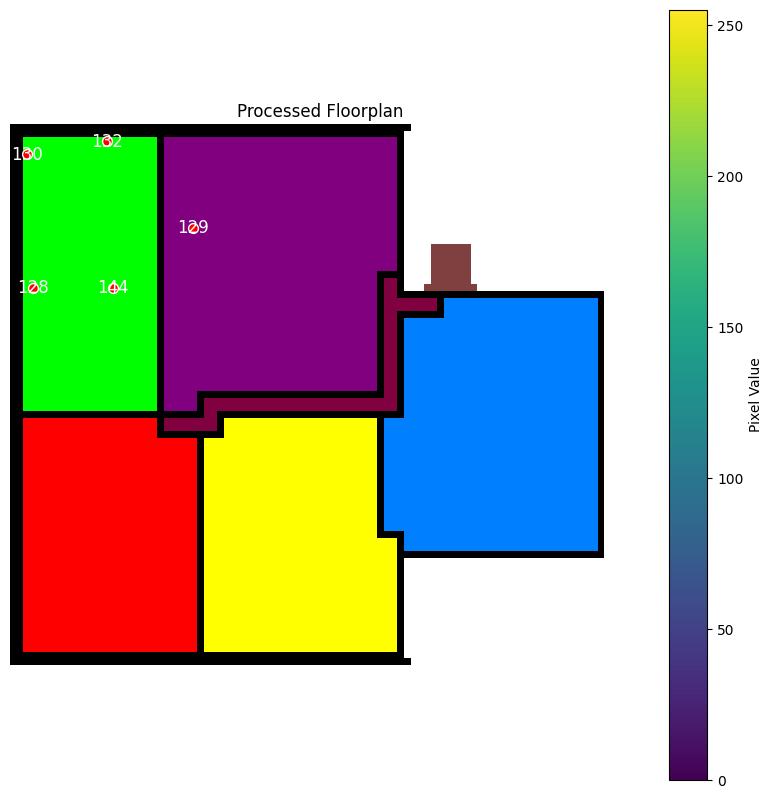

[(3, 8), (3, 36), (5, 36), (5, 51), (15, 23), (15, 32), (16, 3), (16, 8), (19, 23), (19, 32), (24, 36), (24, 51), (33, 3), (33, 36)]
(15, 8, 128)
(29, 9, 144)
(42, 14, 129)
(11, 25, 130)
(27, 26, 132)


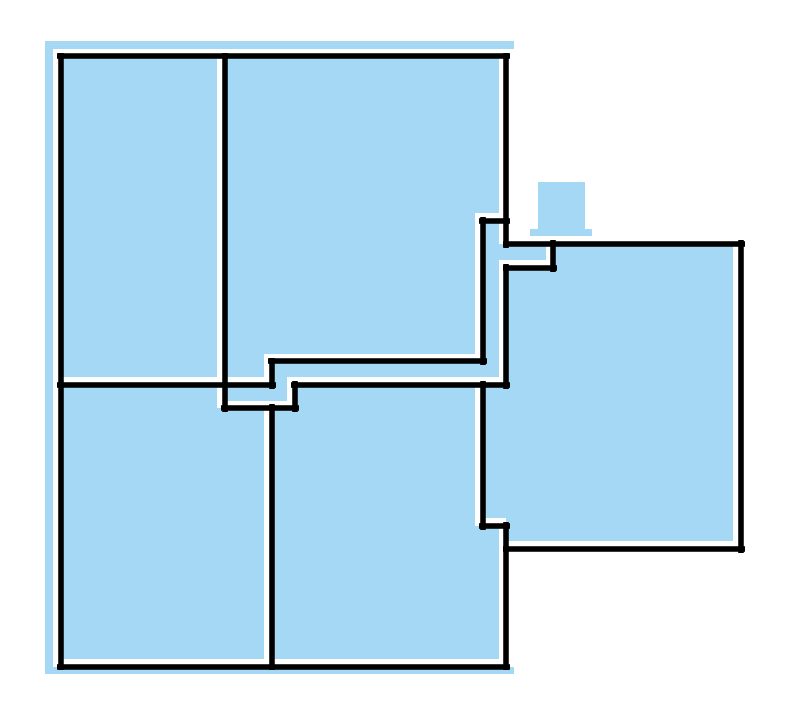

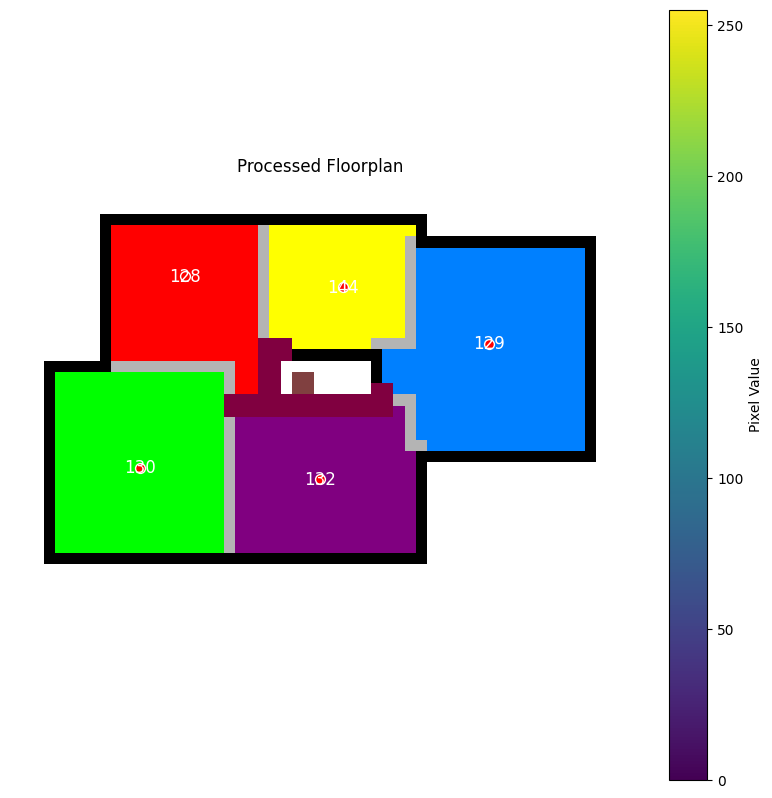

(15, 8, 128)
(29, 9, 144)
(42, 14, 129)
(11, 25, 130)
(27, 26, 132)


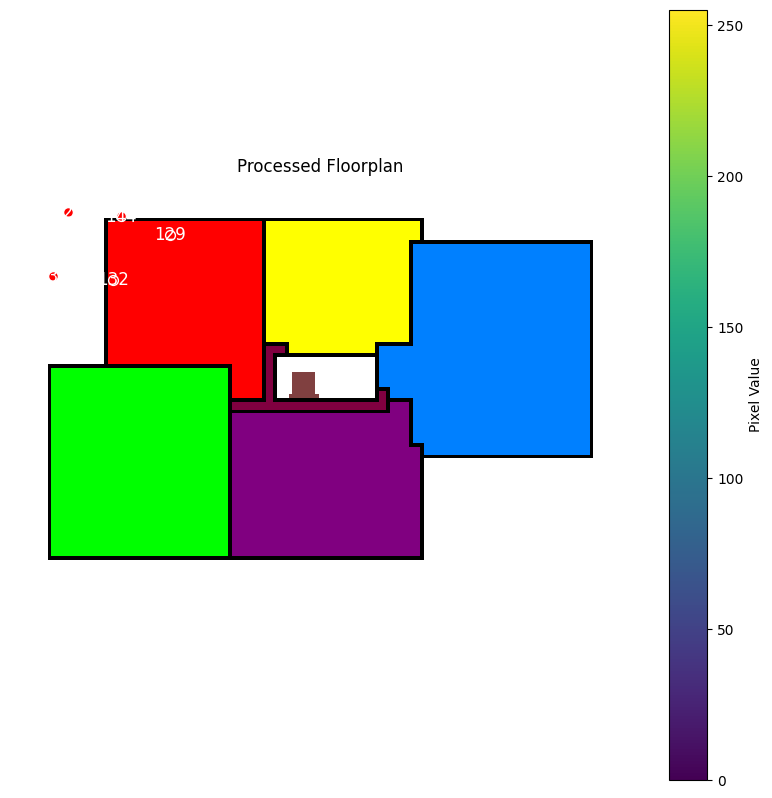

[(2, 14), (2, 43), (4, 2), (4, 14), (4, 43), (4, 55), (25, 2), (25, 14), (27, 14), (27, 43), (39, 43), (39, 55)]
(52, 6, 128)
(14, 8, 144)
(37, 21, 132)
(6, 22, 130)
(49, 34, 129)


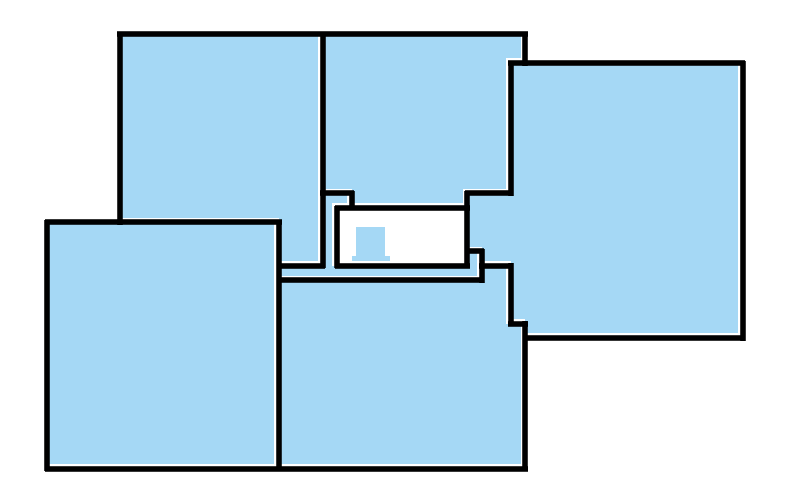

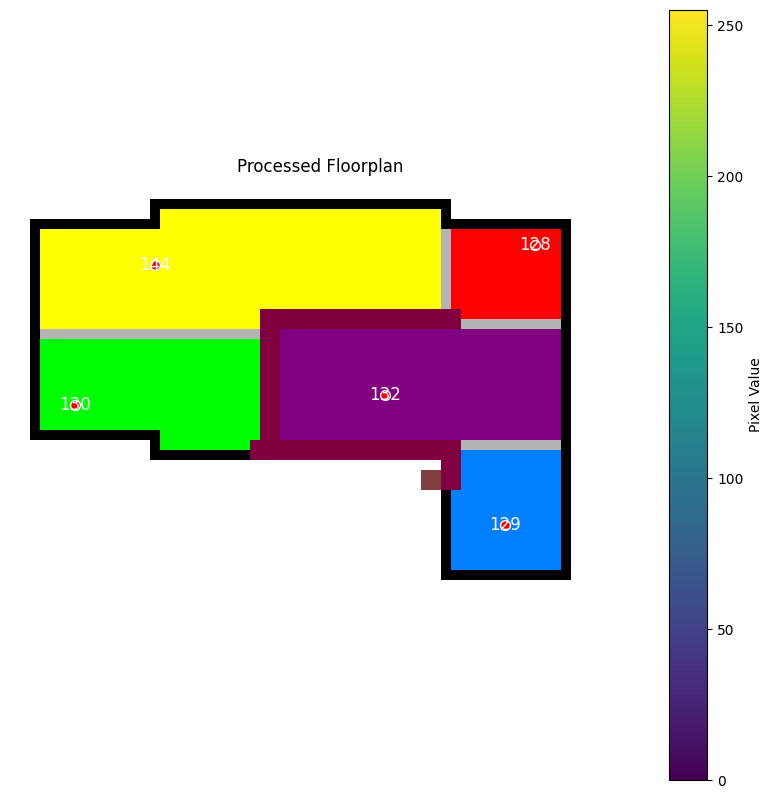

(52, 6, 128)
(14, 8, 144)
(37, 21, 132)
(6, 22, 130)
(49, 34, 129)


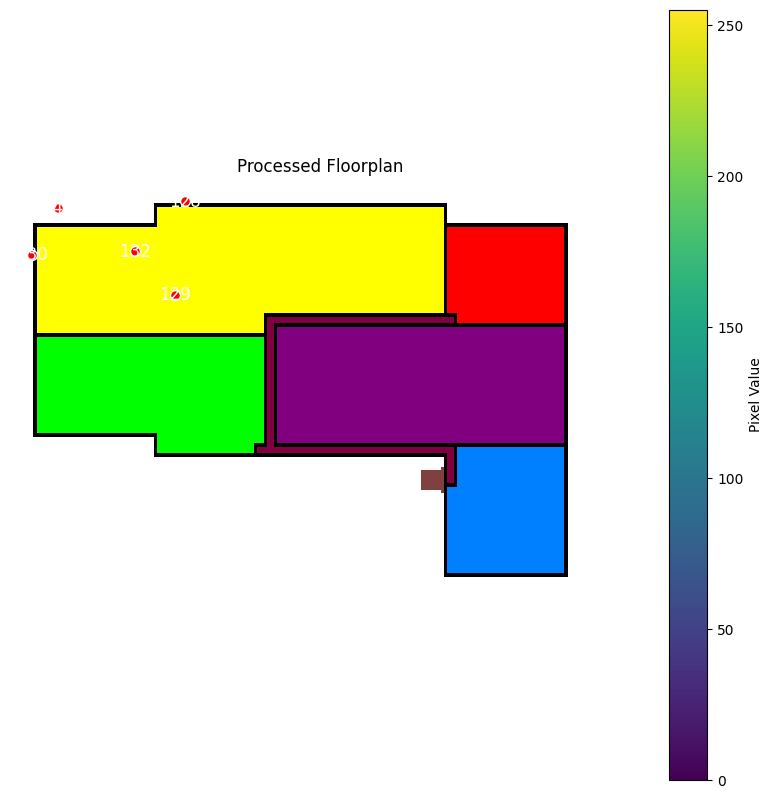

[(2, 2), (2, 42), (14, 15), (14, 29), (29, 2), (29, 15), (29, 29), (29, 42)]
(17, 4, 144)
(36, 5, 132)
(8, 14, 129)
(8, 26, 128)
(36, 27, 130)


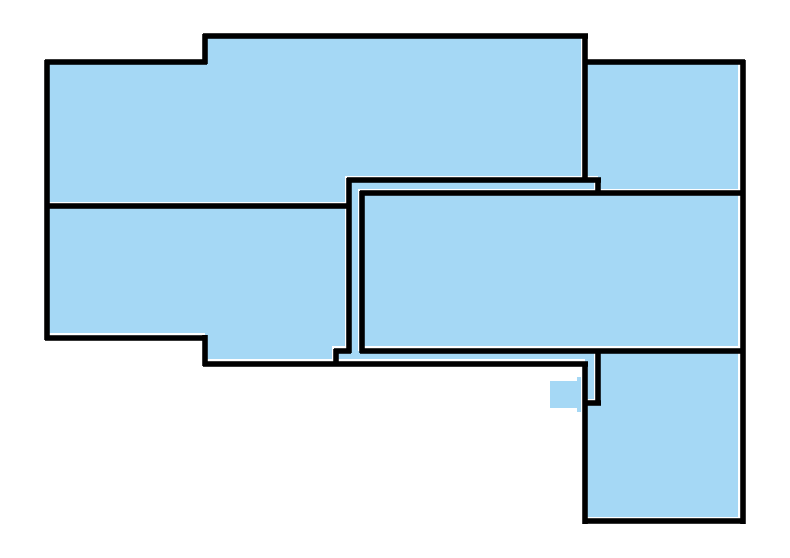

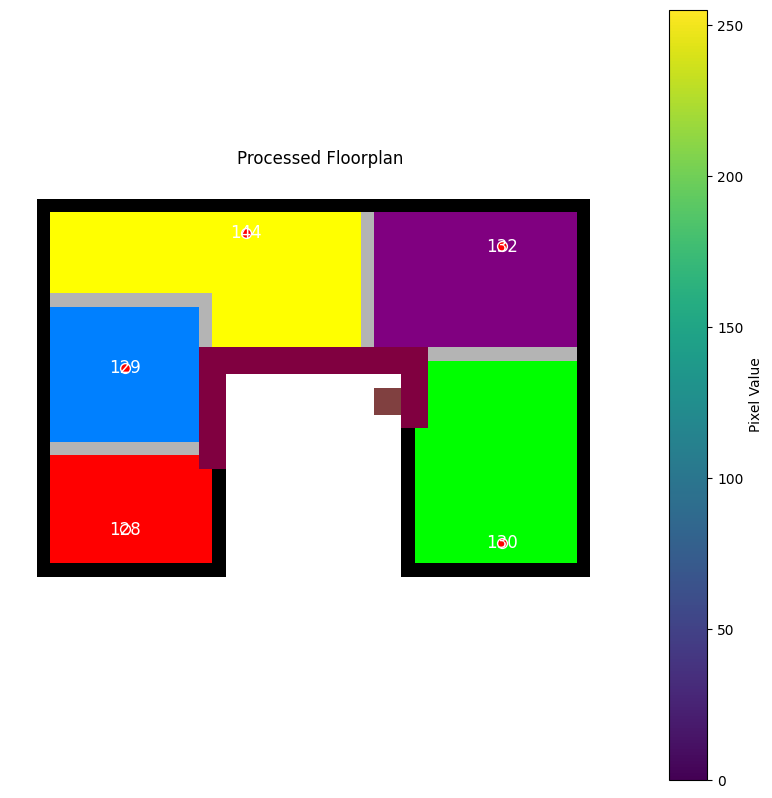

(17, 4, 144)
(36, 5, 132)
(8, 14, 129)
(8, 26, 128)
(36, 27, 130)


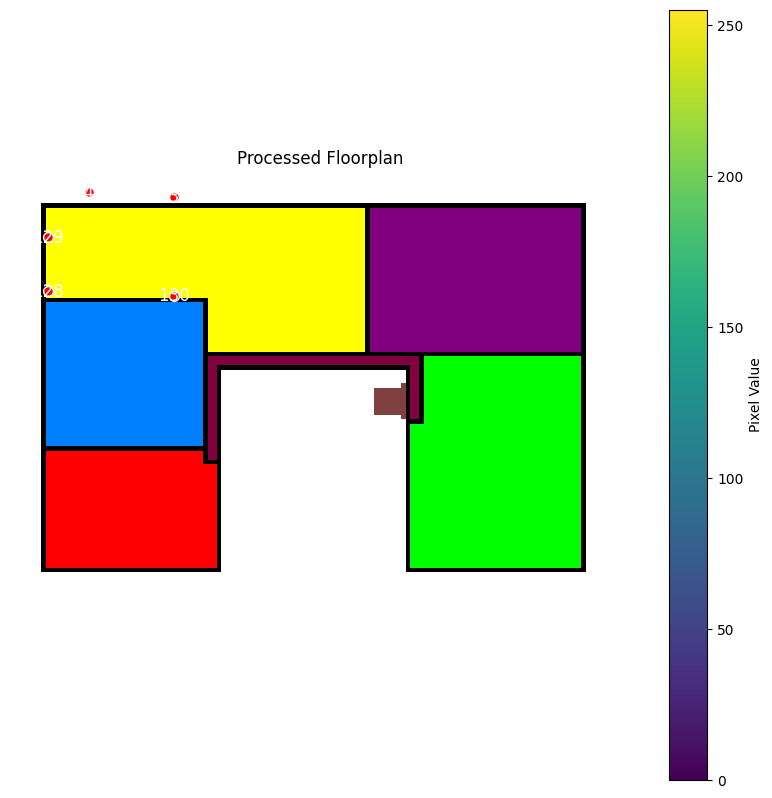

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (33, 1), (33, 30)]
(4, 5, 129)
(24, 5, 132)
(3, 30, 144)
(14, 30, 130)
(26, 30, 128)


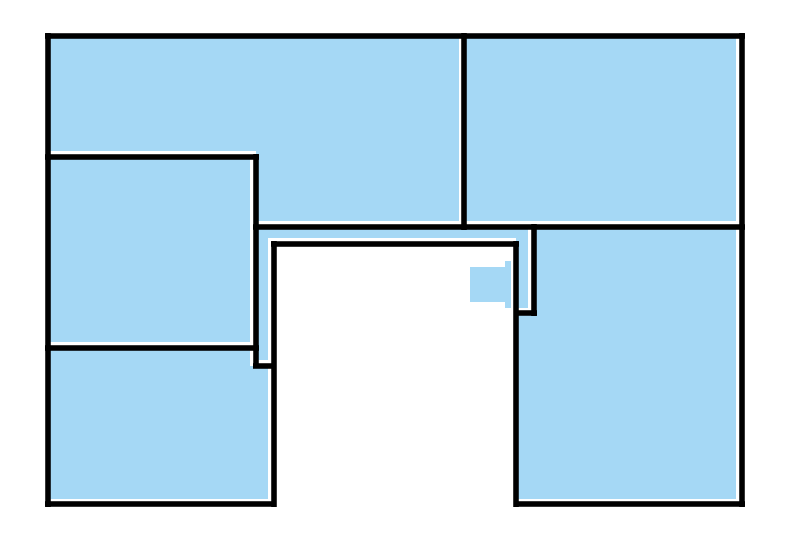

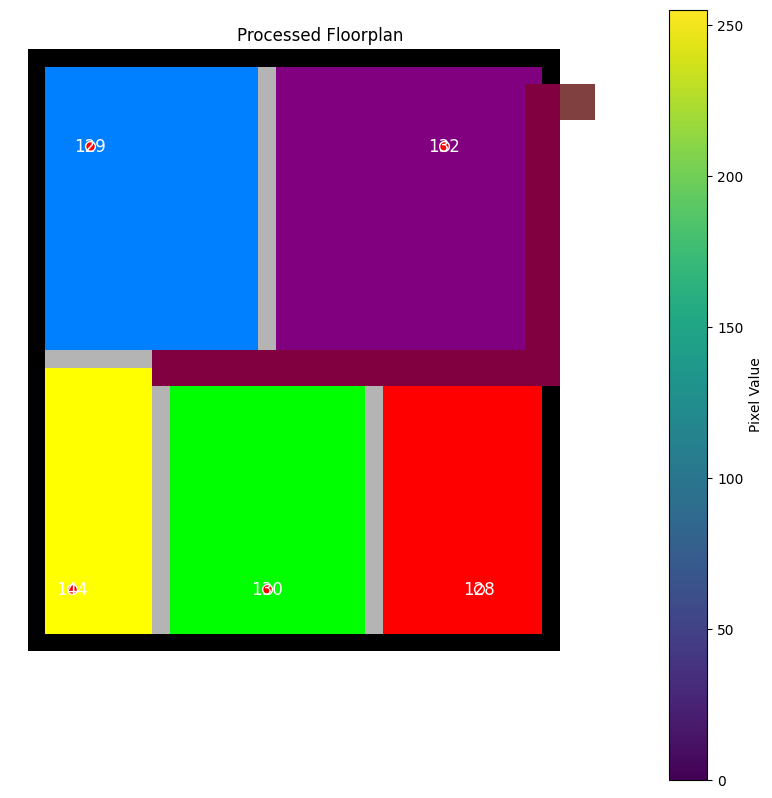

(4, 5, 129)
(24, 5, 132)
(3, 30, 144)
(14, 30, 130)
(26, 30, 128)


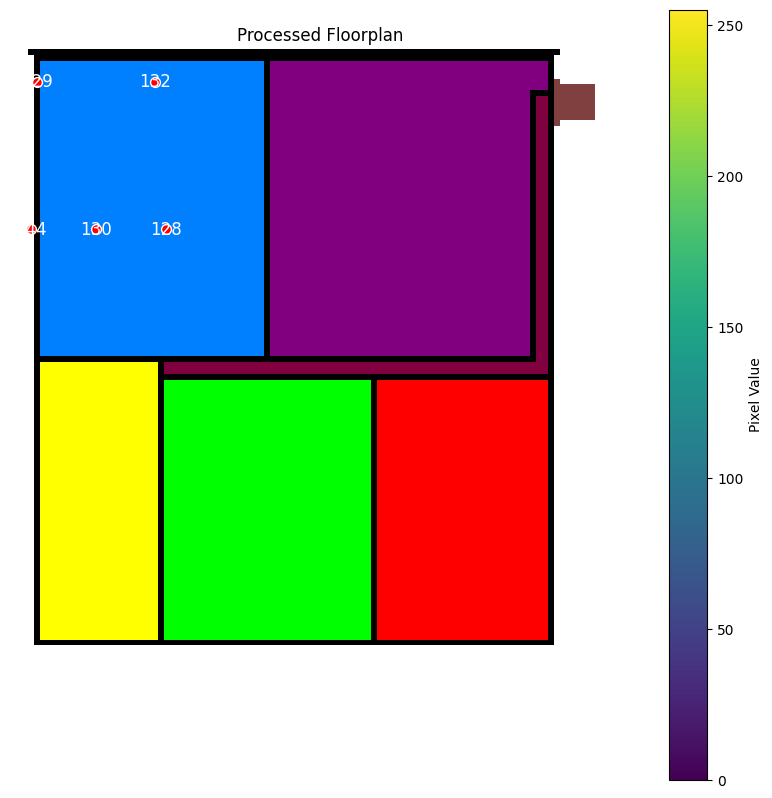

[(1, 1), (1, 24), (6, 9), (6, 11), (8, 9), (8, 11), (10, 24), (10, 40), (17, 12), (17, 28), (23, 12), (23, 28), (29, 1), (29, 40)]
(5, 5, 128)
(15, 13, 144)
(35, 13, 129)
(4, 27, 130)
(33, 27, 132)


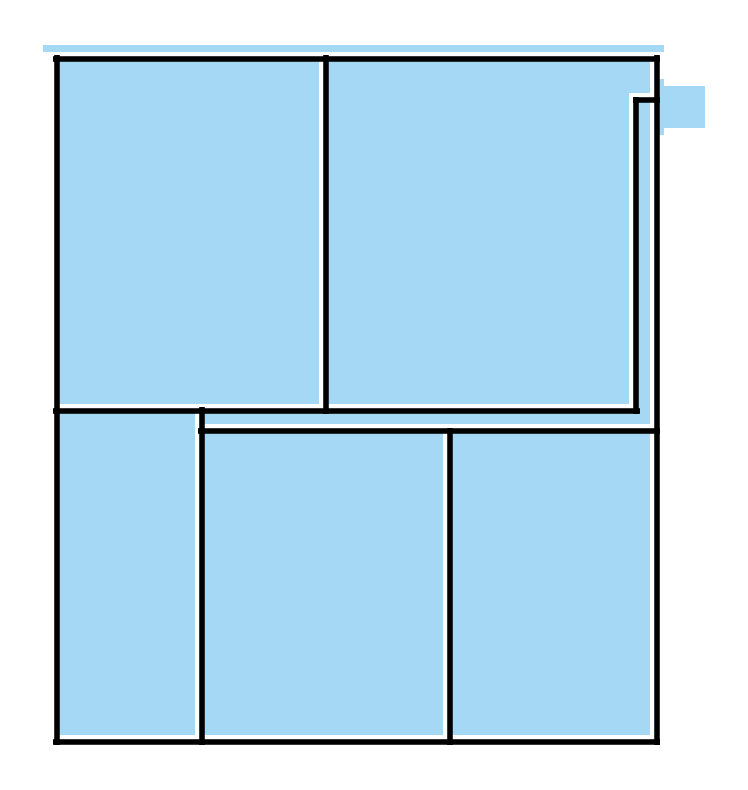

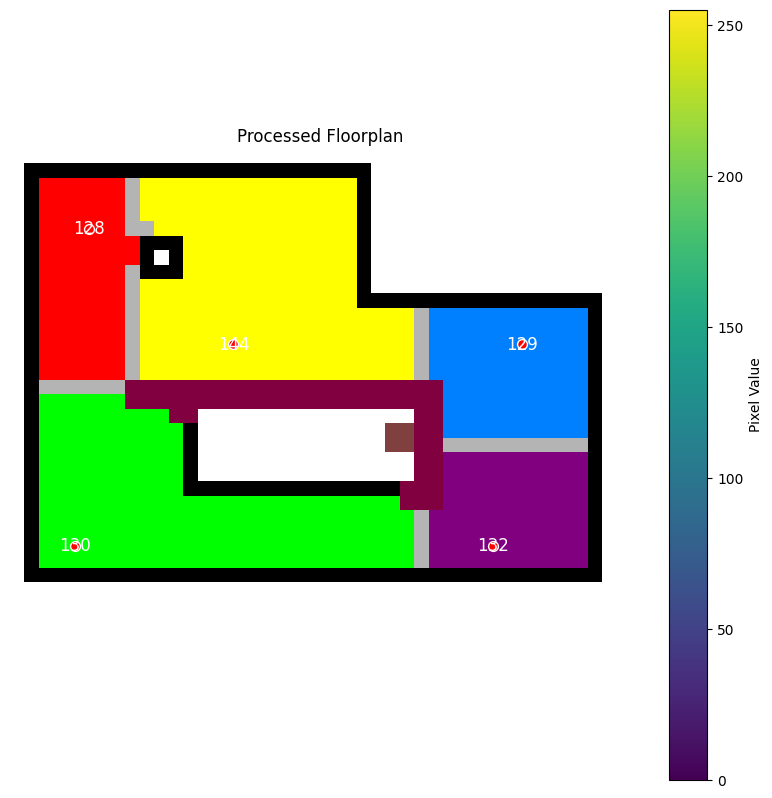

(5, 5, 128)
(15, 13, 144)
(35, 13, 129)
(4, 27, 130)
(33, 27, 132)


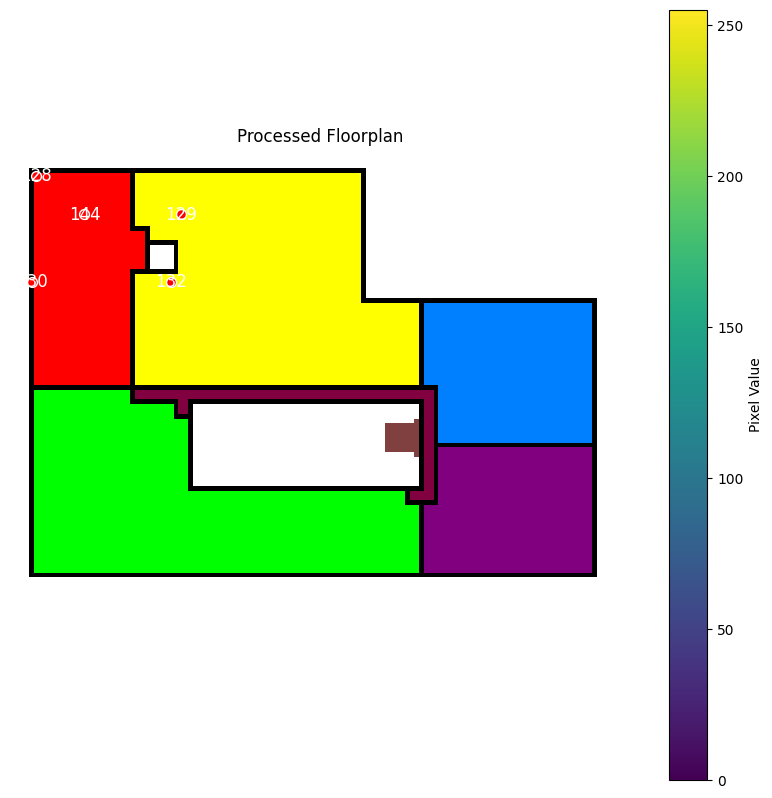

[(0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (2, 5), (2, 39), (4, 0), (4, 5), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (12, 5), (15, 5), (15, 39), (19, 39), (19, 56)]
(31, 4, 130)
(7, 5, 128)
(53, 9, 132)
(8, 13, 129)
(31, 14, 144)


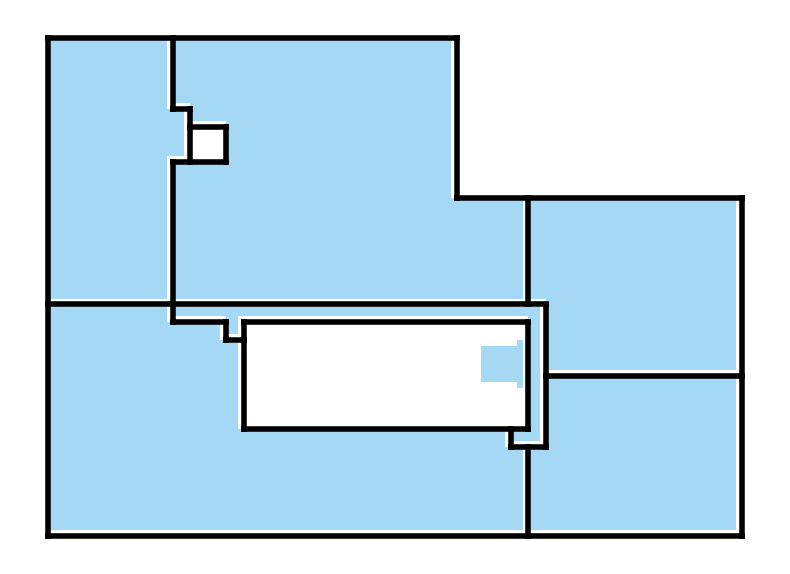

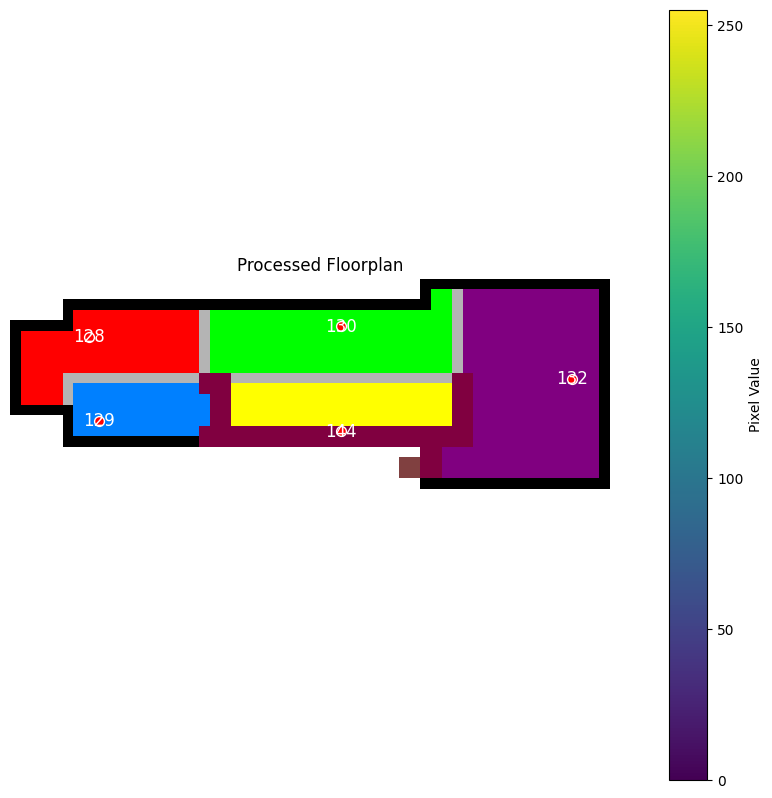

(31, 4, 130)
(7, 5, 128)
(53, 9, 132)
(8, 13, 129)
(31, 14, 144)


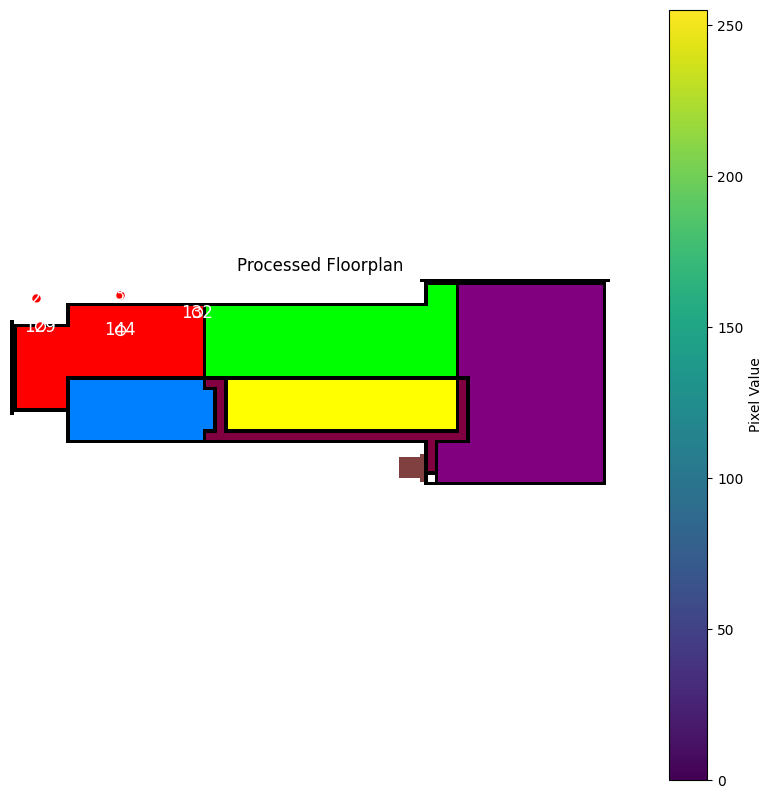

[(0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (8, 0), (8, 20), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (17, 17), (17, 24), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (26, 42), (26, 66), (27, 0), (28, 0), (29, 0), (30, 0), (30, 17), (30, 24), (31, 0), (32, 0), (33, 0), (33, 40), (33, 45), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (38, 40), (38, 45), (39, 0), (39, 20), (45, 42), (45, 66), (50, 20), (50, 42)]
(34, 8, 144)
(3, 11, 130)
(3, 36, 128)
(60, 36, 129)
(23, 48, 136)


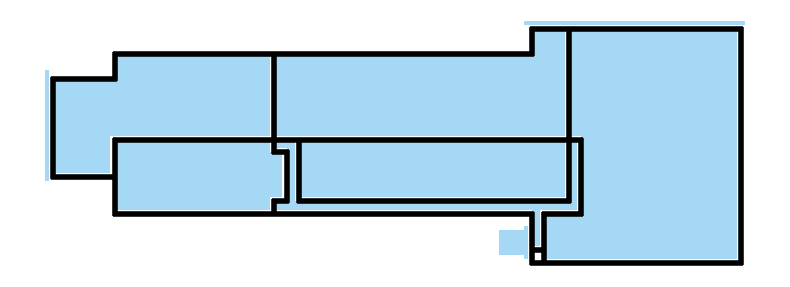

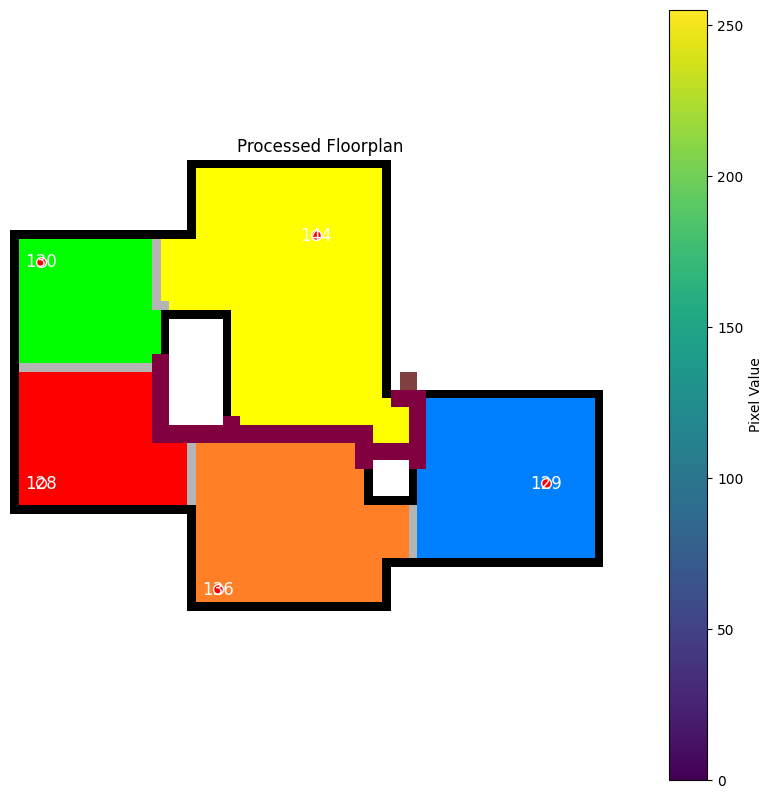

(34, 8, 144)
(3, 11, 130)
(3, 36, 128)
(60, 36, 129)
(23, 48, 136)


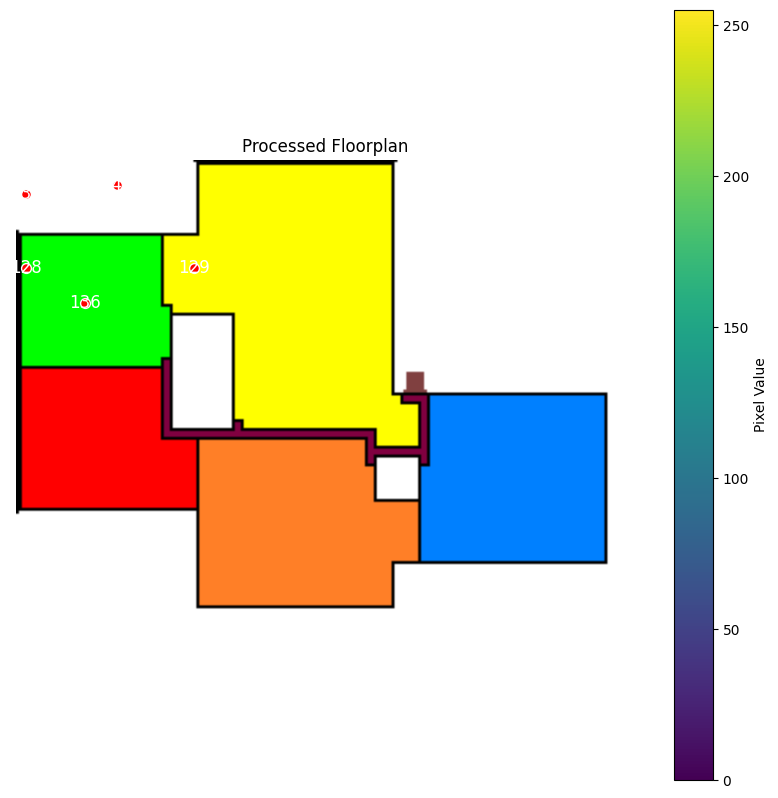

[(0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (4, 5), (4, 17), (6, 0), (6, 5), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (12, 20), (12, 22), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (17, 20), (17, 22), (18, 0), (18, 5), (20, 5), (20, 11), (30, 11), (30, 16), (34, 16), (34, 33)]
(28, 3, 129)
(2, 13, 132)
(30, 16, 130)
(13, 28, 144)
(31, 31, 128)


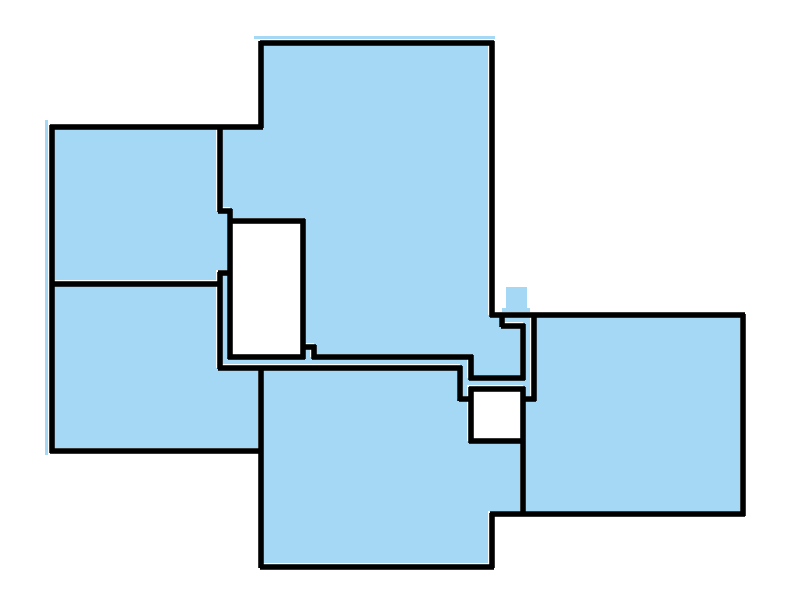

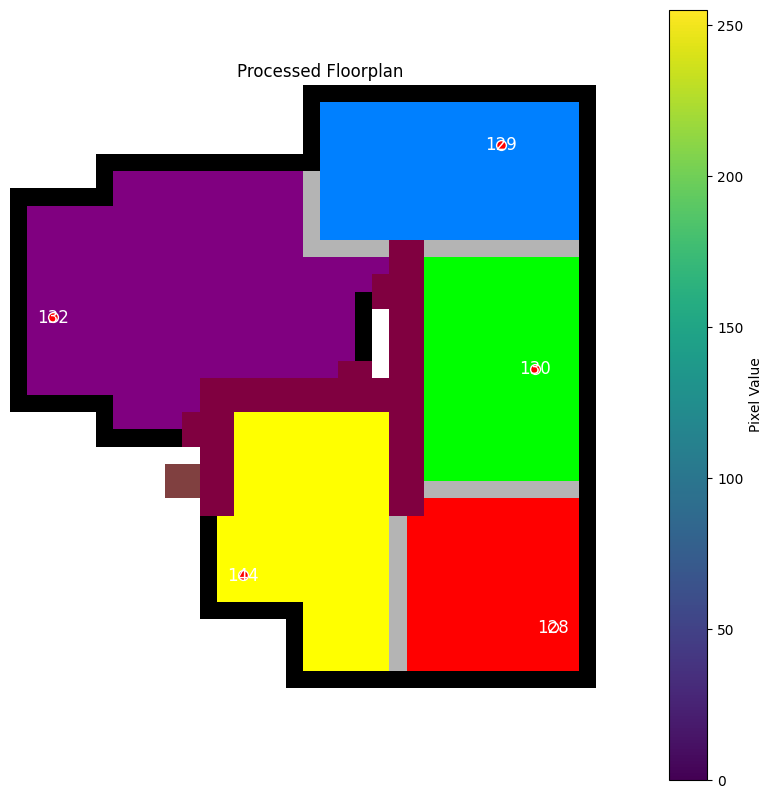

(28, 3, 129)
(2, 13, 132)
(30, 16, 130)
(13, 28, 144)
(31, 31, 128)


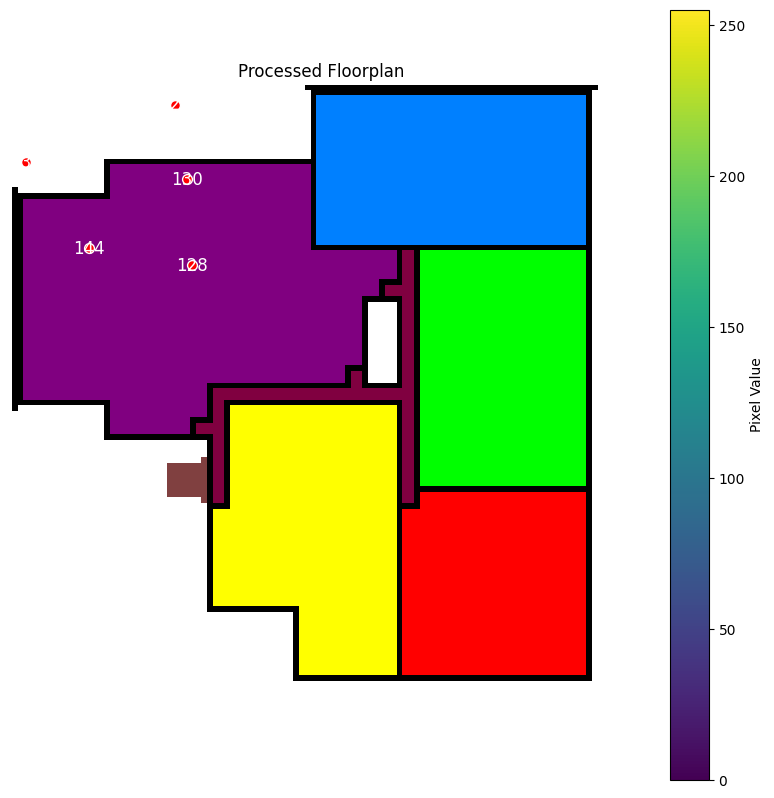

[(1, 6), (1, 30), (24, 16), (24, 21), (32, 1), (32, 6), (32, 30), (32, 36), (39, 16), (39, 21), (44, 1), (44, 36)]
(8, 4, 129)
(27, 4, 144)
(27, 20, 132)
(5, 39, 128)
(29, 39, 130)


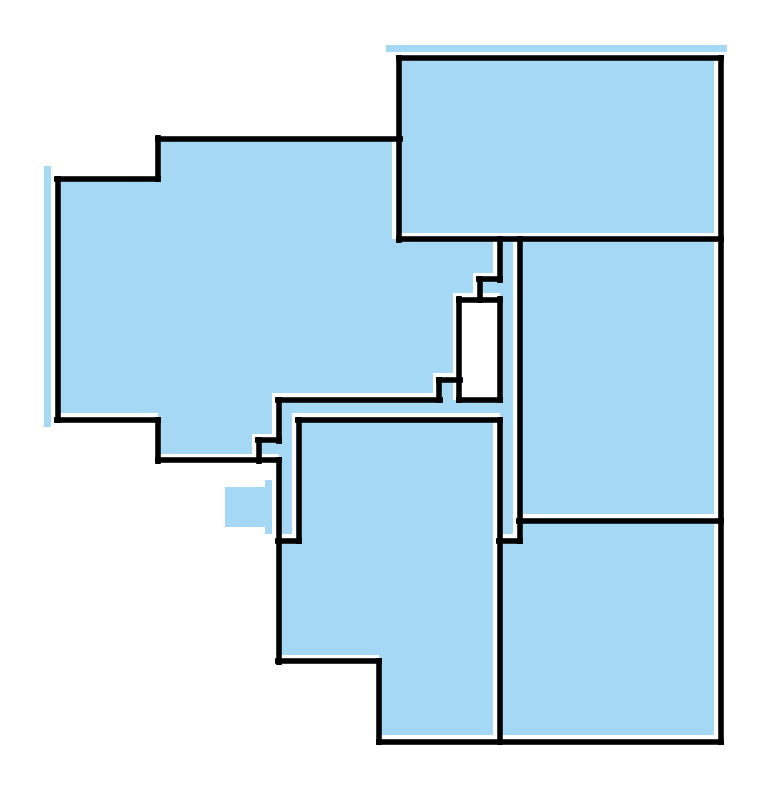

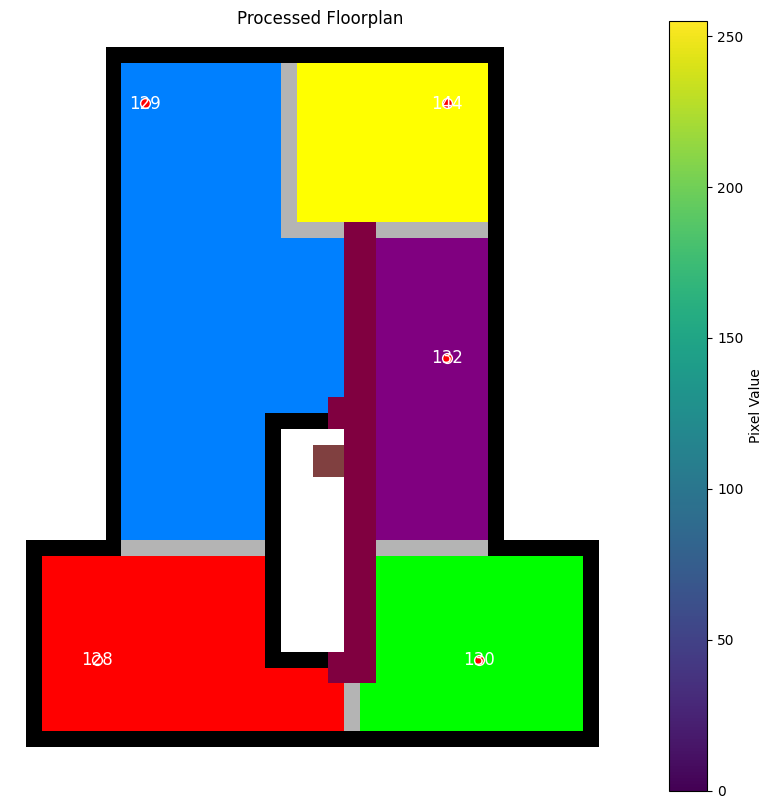

(8, 4, 129)
(27, 4, 144)
(27, 20, 132)
(5, 39, 128)
(29, 39, 130)


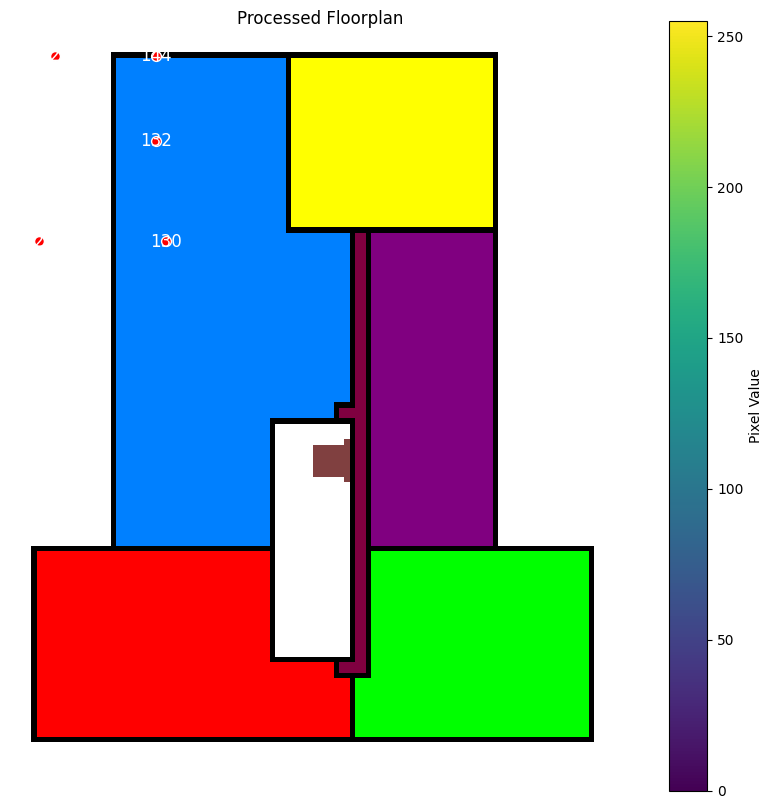

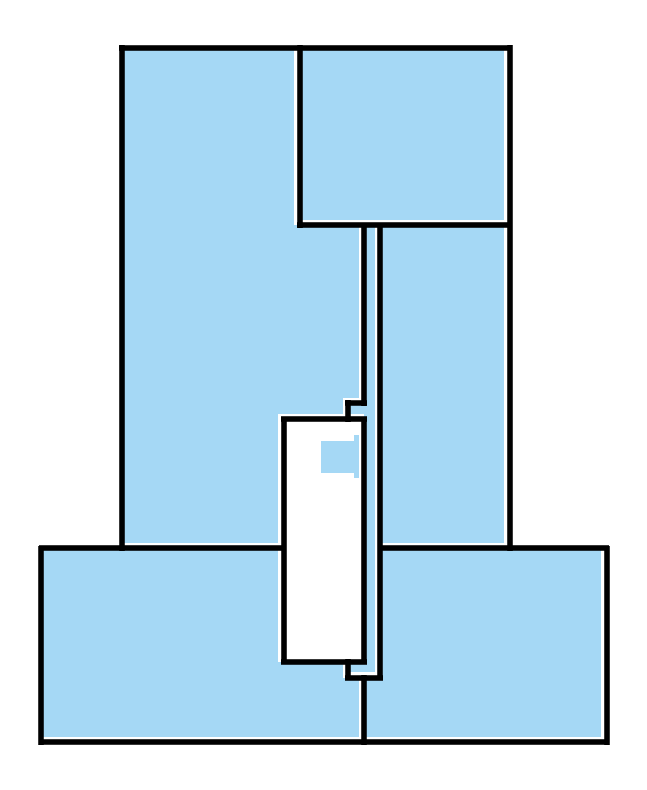

In [5]:
floorplans_int = []
all_seeds = []
from floor import FloorPlan



for floorplan in floorplans:
    floorplan_int, seed_list = image_to_int(floorplan)
    fp = FloorPlan(floorplan_int, seed_list)
    #print(floorplan.shape)
    # Optionally plot the floorplan with seed locations
    # plot_floorplan(floorplan_int, seed_list)
    
    floorplans_int.append(floorplan_int)
    #fp.grid = make_organic_walls(fp.grid)

    #fp.generate_wfc()
    #fp.visualize()
    fp.grow_regions(rectangular=True)
    #fp.show()
    # Optionally generate mapping rectangles, fill rooms and refine walls
    #fp.generate_mapping_rectangles()
    fp.generate_stairs()
    fp.generate_corridors()
    
    # Display the result
    fp.show()
    fp.go_to_3x3()
    #print(fp.grid)
    fp.go_to_3x3int()
    #plt.imshow(fp.room_grid, cmap="viridis", vmin=0, vmax=255)
    #fp.corridor_into_room()
    fp.show()
    grid_to_plot = parse_grid_to_blueprint(fp.grid)
    
    #print(grid_to_plot)
    visualize_blueprint(grid_to_plot)
    #fp.set_grid(int_to_wall(fp.grid))
    #print(fp.grid)
    #print(f"this is cell {np.array(fp.grid[1][1].ins).shape}")
    #plot_rect((fp.grid.shape[1], fp.grid.shape[0]), fp.grid)
    #horizontal_walls, vertical_walls = parse_grid_to_blueprint(fp.grid)
    #horiz_segments = extract_segments(horizontal_walls, is_horizontal=True)
    #vert_segments = extract_segments(vertical_walls, is_horizontal=False)
    #plot_blueprint(horiz_segments, vert_segments, len(fp.grid), len(fp.grid[0]))

    
    #generate_svg(grid_svg, cell_size=10, output_file="complex_layout.svg")


In [6]:
"""
grid_simple = [
    [0, 0, ],
    [0, 0, ],
]
fp = FloorPlan(np.array(grid_simple), seeds=[])
    # Optionally plot the floorplan with seed locations
    # plot_floorplan(floorplan_int, seed_list)
    

fp.show()
fp.generate_wfc()


fp.show()
"""


'\ngrid_simple = [\n    [0, 0, ],\n    [0, 0, ],\n]\nfp = FloorPlan(np.array(grid_simple), seeds=[])\n    # Optionally plot the floorplan with seed locations\n    # plot_floorplan(floorplan_int, seed_list)\n    \n\nfp.show()\nfp.generate_wfc()\n\n\nfp.show()\n'